In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from FewShotTestHandler import extract_test_result_sequence

/home/rob/vlm_benchmark/FewShotTestHandler.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
test_results = pd.read_csv("test_results.csv")

In [5]:
def column_value_formatter(col, val):
    # Format value
    if col == "vlm_class":
        transform = {
            "ClipVLM": "CLIP",
            "MILES_SimilarityVLM": "MILES",
            "VideoClipVLM": "VideoCLIP"
        }
        return transform.get(val, val)
    
    if col == "dataset":
        name, split = val.split(".")
            
        transform = {
            "kinetics_100": "Kinetics-100",
            "moma_act": "MOMA Activity",
            "moma_sact": "MOMA Sub-Activity"
        }
        
        result = transform.get(name, name)
        if split != "all":
            result += f" ({split})"
        return result
    
    if col == "n_way":
        return f"{val}-way"
    
    if col == "n_support":
        return f"{val}-shot"
    
    if col == "classifier.text_weight":
        return f"text_weight: {val}"
    
    return f"{col}: {val}"

def column_description(col):
    if col == "n_support":
        return "Support Videos"
    
    if col == "classifier.text_weight":
        return "Text Weight"
    
    return col

In [6]:
def plot(results, x_col, y_col, plot_descriptor_cols, line_descriptor_cols, filter_dict = {}):
    grouped_results = extract_test_result_sequence(results, x_col, y_col, filter=filter_dict)
    print(f"{len(grouped_results)} Overall Lines")
    
    plot_descriptors = grouped_results.reset_index().groupby(plot_descriptor_cols, as_index=False, dropna=False).agg({"index": list})
    print(f"{len(plot_descriptors)} Separate Plots")
    
    for plot_descriptor in plot_descriptors.itertuples():
        plot_name = ", ".join([column_value_formatter(col, getattr(plot_descriptor, col)) for col in plot_descriptor_cols])
        
        fig, ax = plt.subplots(figsize=(8,4))
        fig.suptitle(plot_name, fontsize=15)
        
        lines = grouped_results.loc[plot_descriptor.index].reset_index()
        
        for i in range(len(lines)):
            line_name = ", ".join([column_value_formatter(col, lines.loc[i, col]) for col in line_descriptor_cols])
                
            x, y = lines.loc[i, [x_col, y_col]]
        
            if x_col == "classifier.text_weight" and lines.loc[i, "n_support"] == 0 and len(x) == 1:
                ax.axhline(y[0], label=line_name, linestyle="dashed")
            elif "classifier.text_weight" in line_descriptor_cols and x_col == "n_support" and x[0] == 0:
                ax.scatter([x[0]], [y[0]])
                ax.plot(x[1:], y[1:], label=line_name)
            else:
                ax.plot(x, y, label=line_name)
        
        ax.set_xlabel(column_description(x_col))
        ax.set_ylabel(column_description(y_col))
        if len(lines) > 6:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend()
        fig.show()

In [7]:
# Default filter dict
filter_dict = {
    "classifier_class": ["WeightedTextFewShotClassifier"],
    "dataset": ["kinetics_100.all", "moma_act.all", "moma_sact.all"],
    "n_way": [5, 50],
    "classifier.text_weight": [0, 0.1, 0.5, 1, 5, 10]
}

420 Overall Lines
15 Separate Plots


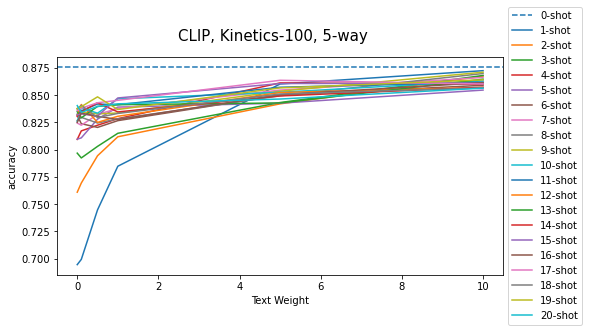

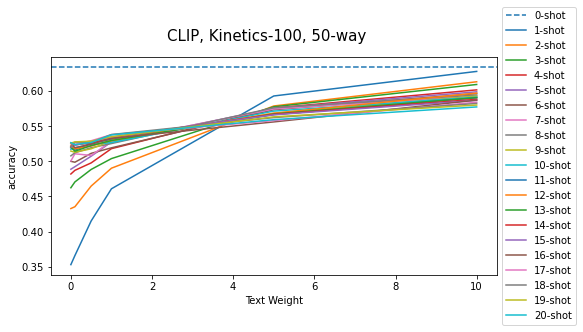

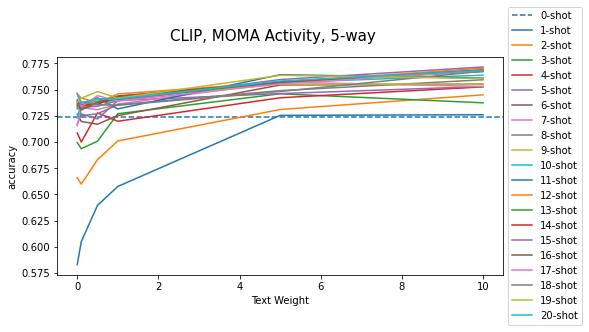

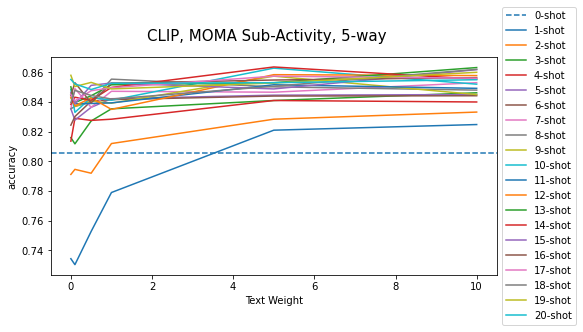

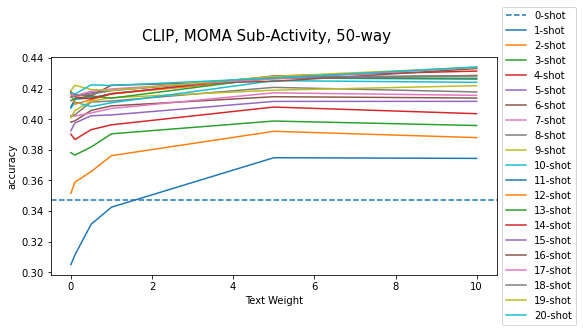

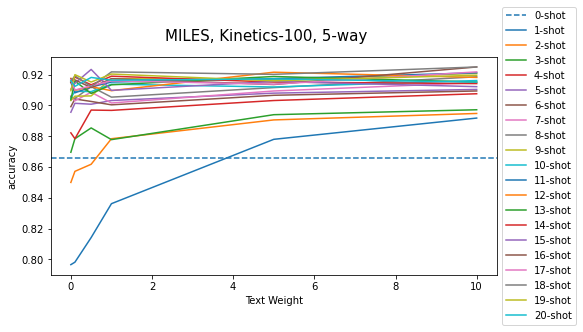

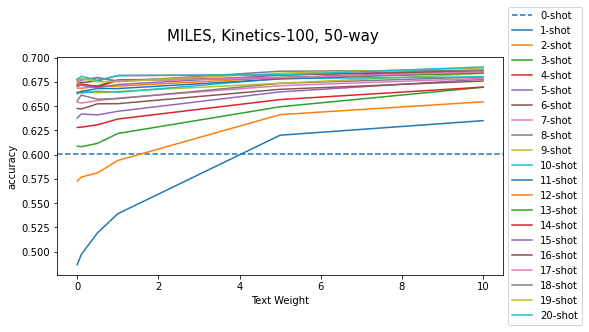

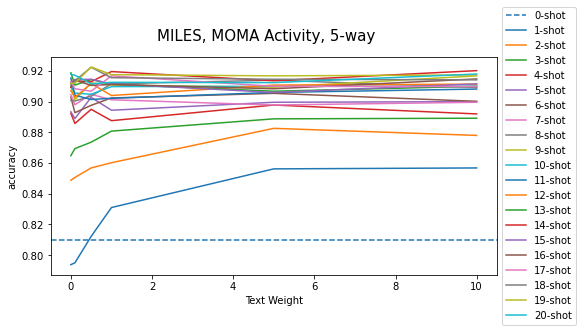

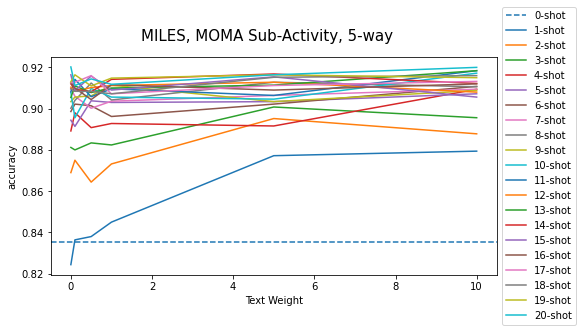

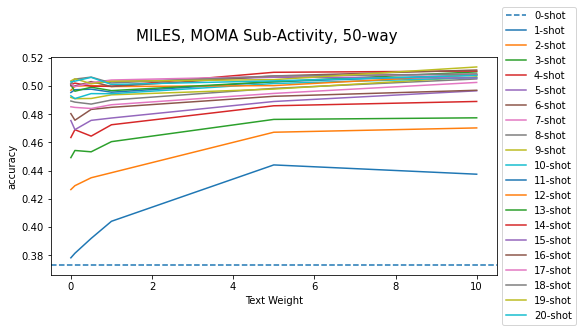

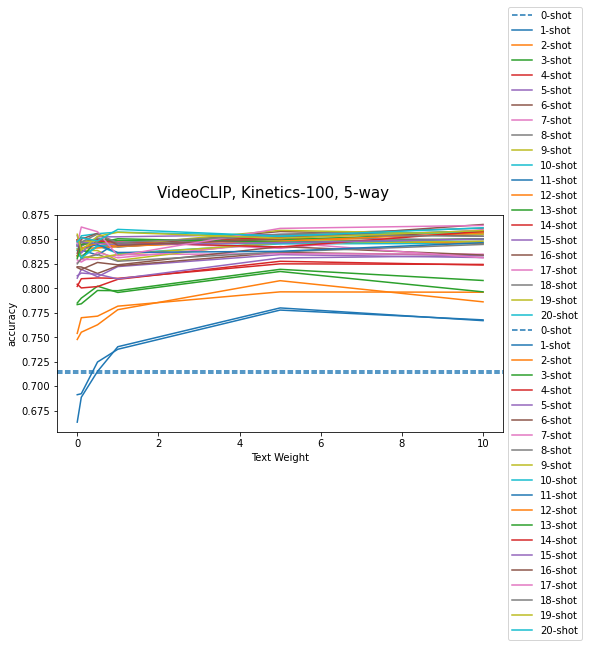

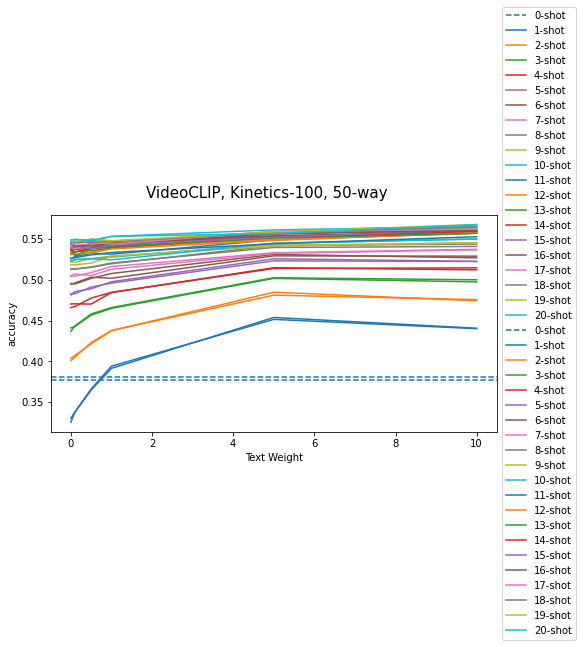

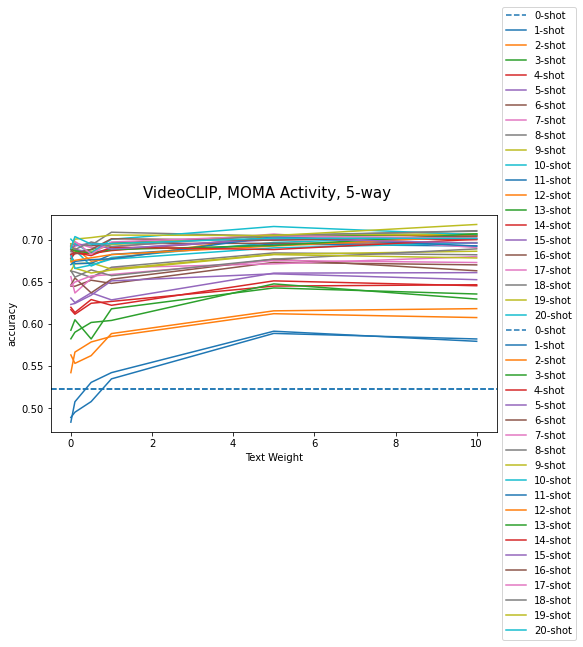

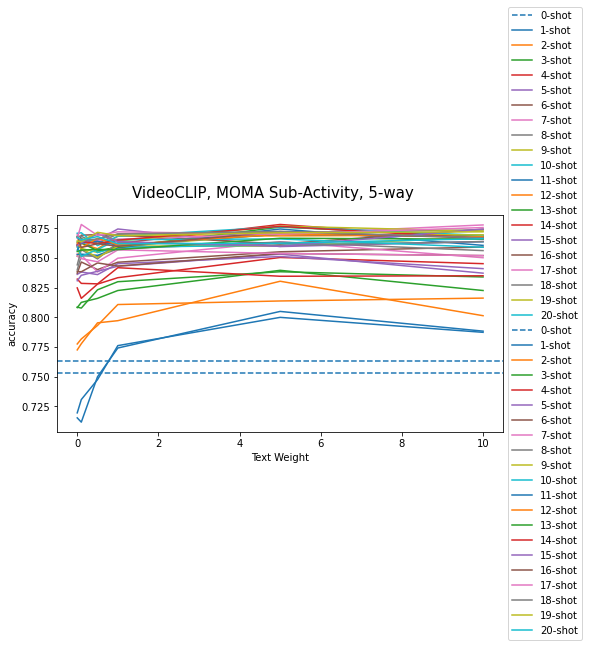

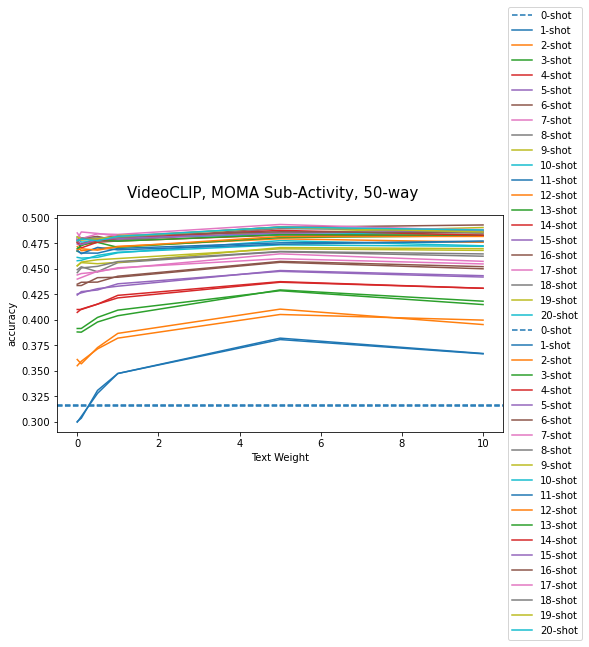

In [8]:
x_col = "classifier.text_weight"
y_col = "accuracy"
plot_descriptor_cols = ["vlm_class", "dataset", "n_way"]    # Create a separate plot for each value of these
line_descriptor_cols = ["n_support"]                        # Create a separate line (with these cols as legend) for each unique val of these

plot(test_results, x_col, y_col, plot_descriptor_cols, line_descriptor_cols, filter_dict)

120 Overall Lines
15 Separate Plots


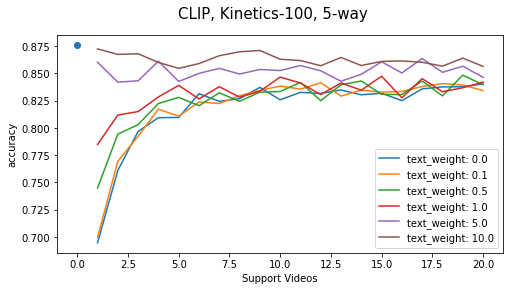

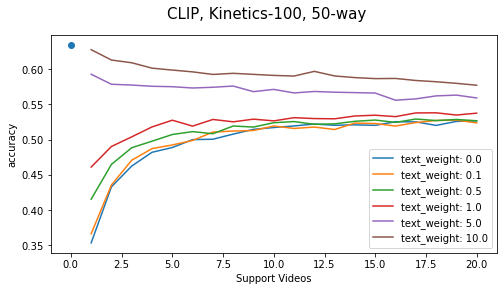

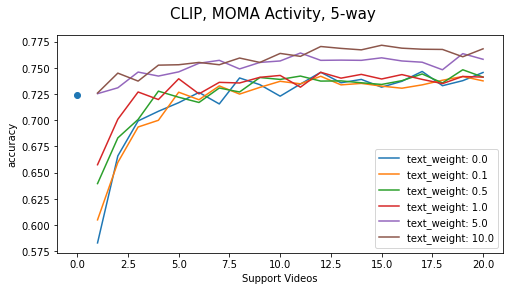

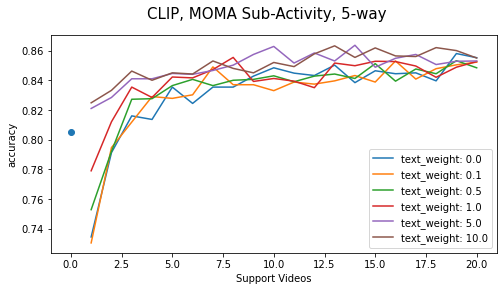

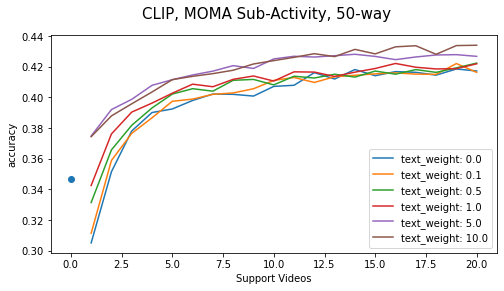

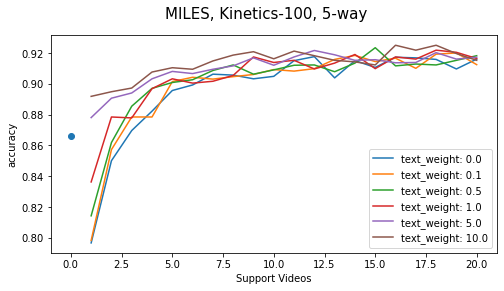

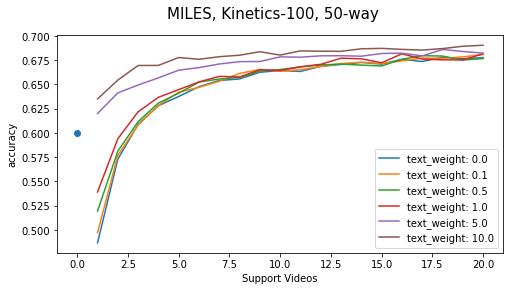

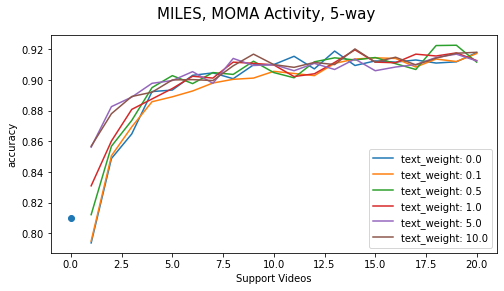

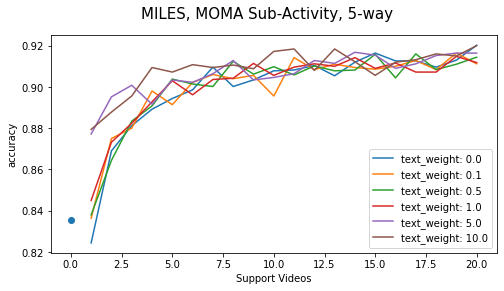

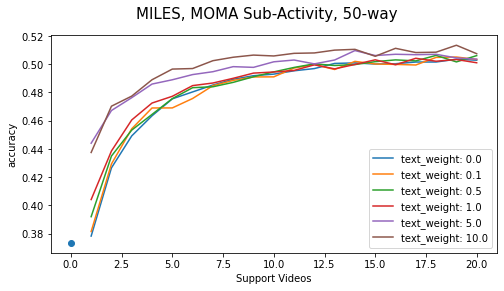

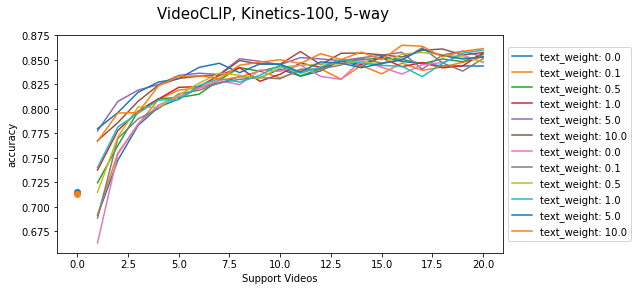

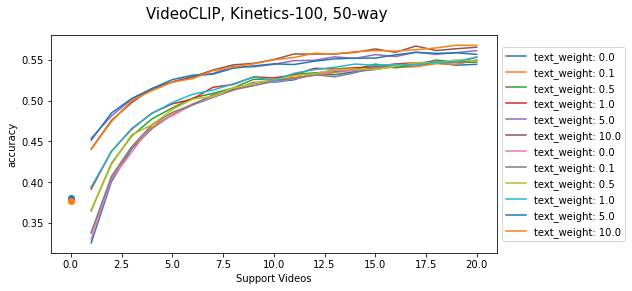

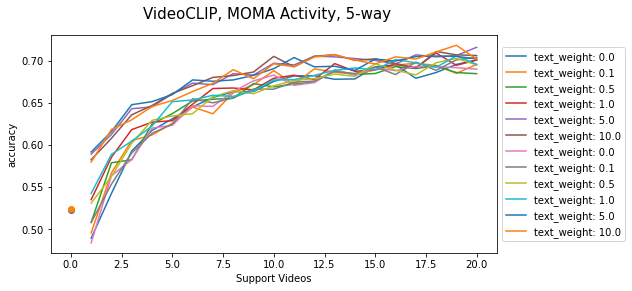

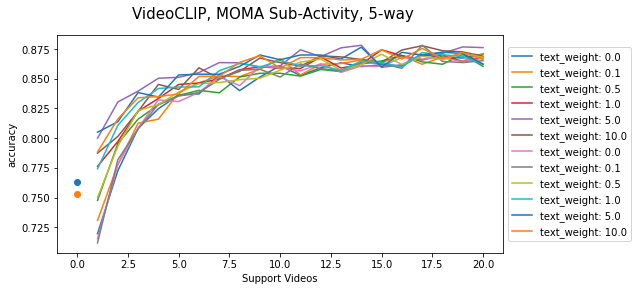

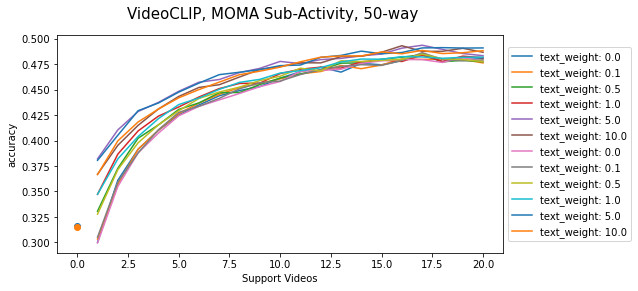

In [9]:
x_col = "n_support"
y_col = "accuracy"
plot_descriptor_cols = ["vlm_class", "dataset", "n_way"]    # Create a separate plot for each value of these
line_descriptor_cols = ["classifier.text_weight"]           # Create a separate line (with these cols as legend) for each unique val of these

plot(test_results, x_col, y_col, plot_descriptor_cols, line_descriptor_cols, filter_dict)

12 Overall Lines
3 Separate Plots


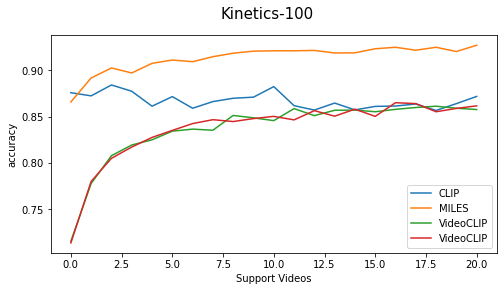

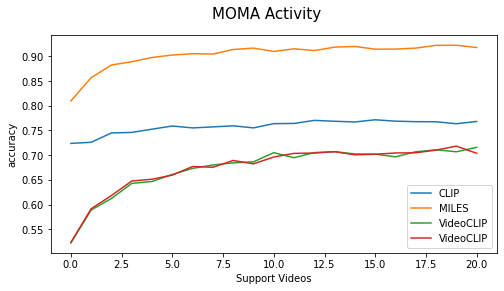

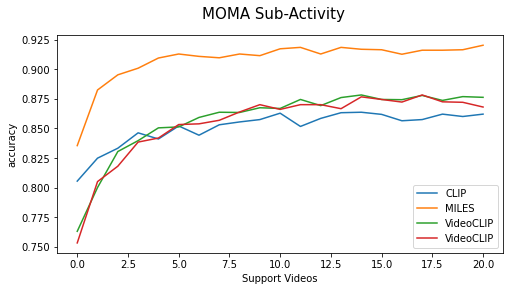

In [10]:
# Maximize over text_weights, then group vlms into the same plots
best_text_weight_results = test_results.groupby(
    [col for col in test_results.columns if col not in ["classifier.text_weight", "accuracy"]],
    as_index=False, dropna=False
).agg({"accuracy": "max"})

new_filter = dict(filter_dict, n_way=[5])

x_col = "n_support"
y_col = "accuracy"
plot_descriptor_cols = ["dataset"]#, "n_way"]    # Create a separate plot for each value of these
line_descriptor_cols = ["vlm_class"]           # Create a separate line (with these cols as legend) for each unique val of these

plot(best_text_weight_results, x_col, y_col, plot_descriptor_cols, line_descriptor_cols, new_filter)

21 Overall Lines
7 Separate Plots


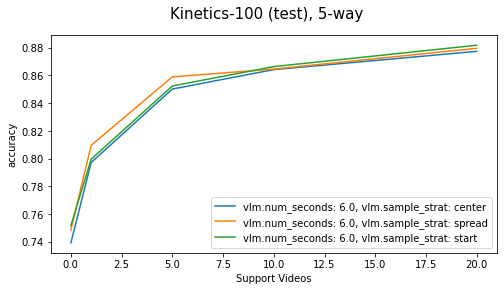

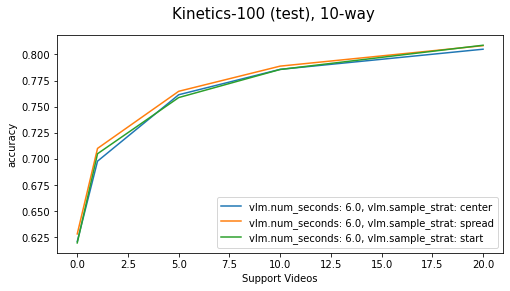

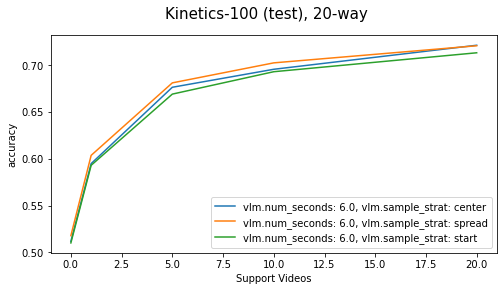

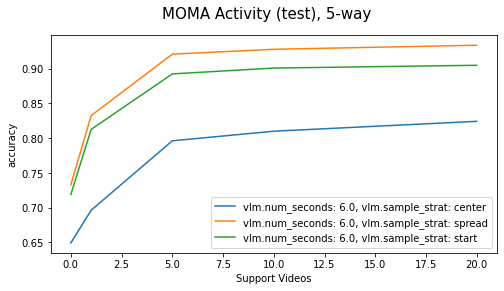

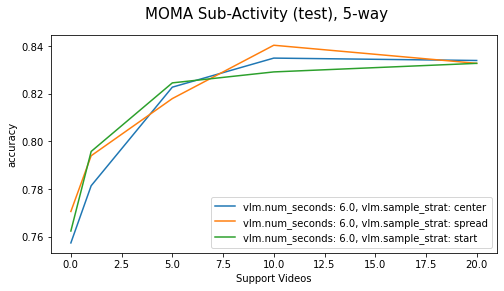

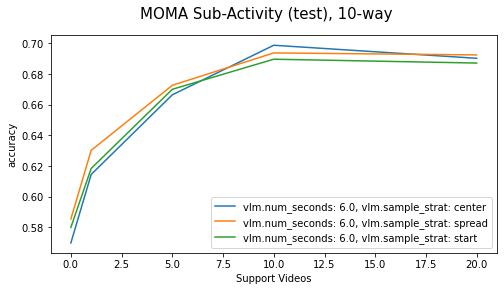

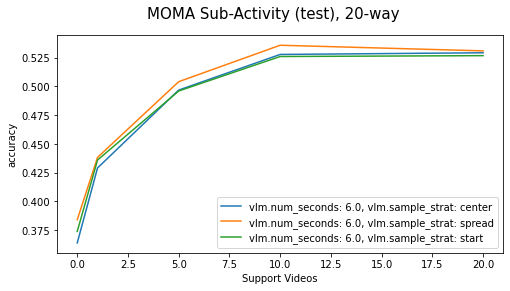

In [11]:

best_text_weight_results = test_results.groupby(
    [col for col in test_results.columns if col not in ["classifier.text_weight", "accuracy"]],
    as_index=False, dropna=False
).agg({"accuracy": "max"})

video_clip_filter = {
    "vlm_class": ["VideoClipVLM"],
    "classifier_class": ["WeightedTextFewShotClassifier"],
    "dataset": ["kinetics_100.test", "moma_act.test", "moma_sact.test"],
    "vlm.num_seconds": [6]
}
x_col = "n_support"
y_col = "accuracy"
plot_descriptor_cols = ["dataset", "n_way"]
line_descriptor_cols = ["vlm.num_seconds", "vlm.sample_strat"]

plot(best_text_weight_results, x_col, y_col, plot_descriptor_cols, line_descriptor_cols, video_clip_filter)

In [12]:
temp_filter_dict = dict(filter_dict, n_support=[0, 1, 5])
temp_filter_dict["n_way"] = [5]
filtered_indices = np.ones(len(test_results)).astype(bool)
for filter_col, filter_val_list in temp_filter_dict.items():
    if filter_col not in test_results.columns:
        continue
    
    valid_col_indices = np.zeros(len(test_results)).astype(bool)
    for filter_val in filter_val_list:
        valid_col_indices = valid_col_indices | (test_results[filter_col] == filter_val)
    filtered_indices = filtered_indices & valid_col_indices
temp_results = test_results[filtered_indices]    

temp_results = temp_results.groupby(
    [col for col in temp_results.columns if col not in ["classifier.text_weight", "accuracy"]],
    as_index=False, dropna=False
).agg({"accuracy": "max"})

In [13]:
temp_results.to_csv("temp.csv")